In [ ]:
import logging

logging.basicConfig(level=logging.DEBUG)
logging.debug('This will get logged')
logging.warning('This will get logged too')
logging.error('This will get logged too')
logging.critical('This will get logged too')

In [75]:
import numpy as np
import pandas as pd
import urllib.request
import tarfile
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
import warnings

In [76]:
sns.set_theme(context='notebook',style='dark')

In [ ]:
def load_data():
    rel_path = Path('datasets/housing.tgz')
    if(not rel_path.is_file()):
        Path("datasets").mkdir(parents=True,exist_ok=True)
        url = 'https://github.com/ageron/data/raw/main/housing.tgz'
        urllib.request.urlretrieve(url,rel_path)
        with tarfile.open(rel_path) as zip:
            zip.extractall(path='datasets')
    return pd.read_csv('datasets/housing/housing.csv')        
housing_data = load_data()
housing_data['ocean_proximity'] = housing_data['ocean_proximity'].astype('category')
print(housing_data.info())
print(housing_data.describe())
print(housing_data['ocean_proximity'].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   longitude           20640 non-null  float64 
 1   latitude            20640 non-null  float64 
 2   housing_median_age  20640 non-null  float64 
 3   total_rooms         20640 non-null  float64 
 4   total_bedrooms      20433 non-null  float64 
 5   population          20640 non-null  float64 
 6   households          20640 non-null  float64 
 7   median_income       20640 non-null  float64 
 8   median_house_value  20640 non-null  float64 
 9   ocean_proximity     20640 non-null  category
dtypes: category(1), float64(9)
memory usage: 1.4 MB
None
          longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.639486   2635.763081   
std        2.003532 

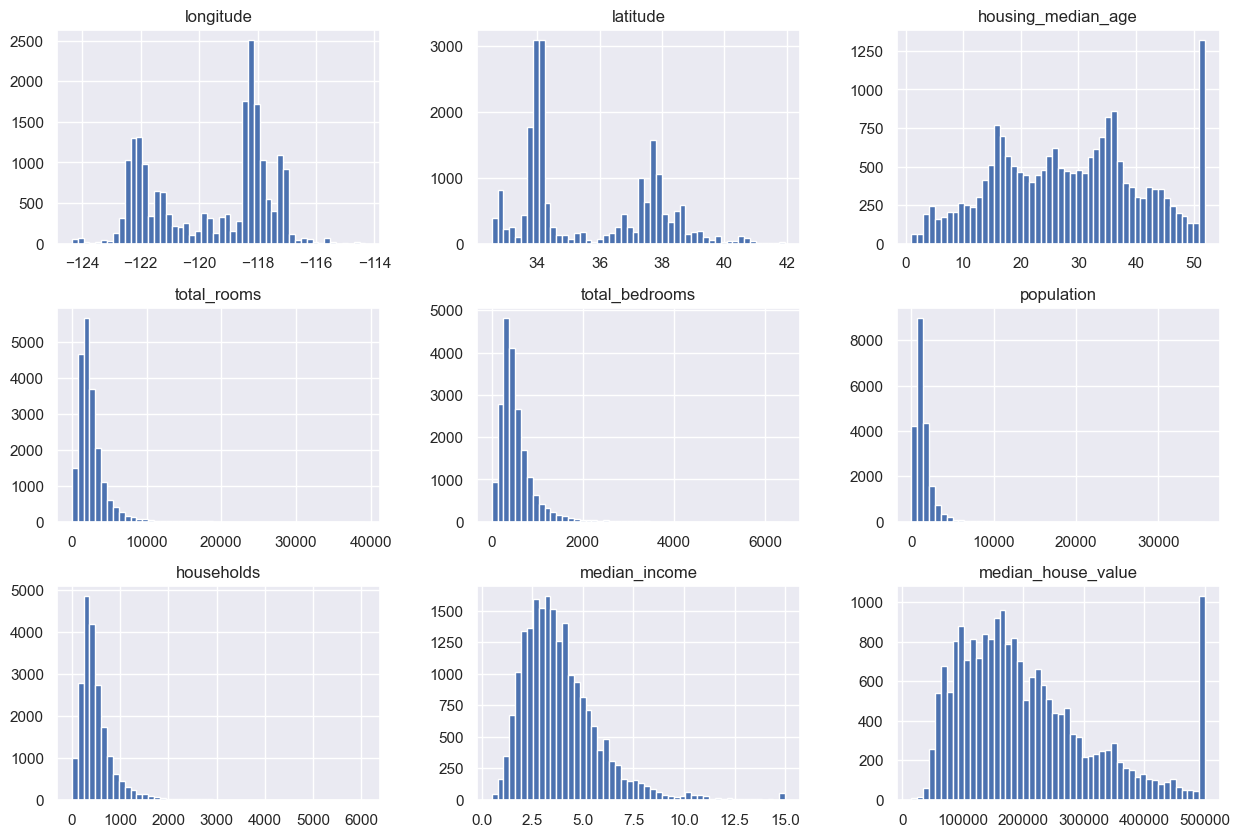

In [78]:
housing_data.hist(figsize=(15,10),bins=50)
plt.show()

In [ ]:
sss = StratifiedShuffleSplit(n_splits=5,test_size=0.2,random_state=42)
housing_data['income_cat'] = pd.cut(housing_data['median_income'],bins=[0,1.5,3,4.5,6,np.inf],labels=[1,2,3,4,5])
print(housing_data['income_cat'].head())
strat_split = []
for train_index,test_index in sss.split(housing_data,housing_data['income_cat']):
    train = housing_data.iloc[train_index]
    test = housing_data.iloc[test_index]
    strat_split.append([train,test])

print(strat_split[0])

0    5
1    5
2    5
3    4
4    3
Name: income_cat, dtype: category
Categories (5, int64): [1 < 2 < 3 < 4 < 5]
[       longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
13096    -122.42     37.80                52.0       3321.0          1115.0   
14973    -118.38     34.14                40.0       1965.0           354.0   
3785     -121.98     38.36                33.0       1083.0           217.0   
14689    -117.11     33.75                17.0       4174.0           851.0   
20507    -118.15     33.77                36.0       4366.0          1211.0   
...          ...       ...                 ...          ...             ...   
14207    -118.40     33.86                41.0       2237.0           597.0   
13105    -119.31     36.32                23.0       2945.0           592.0   
19301    -117.06     32.59                13.0       3920.0           775.0   
19121    -118.40     34.06                37.0       3781.0           873.0   
19888    -122.41  

In [80]:
from sklearn.model_selection import train_test_split
strat_train_set,strat_test_set = train_test_split(housing_data,random_state=42,stratify=housing_data['income_cat'],test_size=0.2)
print("Train set", len(strat_train_set),sep=" - ")
print("Test set", len(strat_test_set),sep=' - ')

Train set - 16512
Test set - 4128


In [81]:
strat_train_set['income_cat'].value_counts() / len(strat_train_set)

income_cat
3    0.350594
2    0.318859
4    0.176296
5    0.114462
1    0.039789
Name: count, dtype: float64

In [82]:
train_set,test_set = train_test_split(housing_data,test_size=0.2,stratify=housing_data['income_cat'])
train_set['income_cat'].value_counts() / len(train_set)
train_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16512 entries, 10985 to 17420
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   longitude           16512 non-null  float64 
 1   latitude            16512 non-null  float64 
 2   housing_median_age  16512 non-null  float64 
 3   total_rooms         16512 non-null  float64 
 4   total_bedrooms      16338 non-null  float64 
 5   population          16512 non-null  float64 
 6   households          16512 non-null  float64 
 7   median_income       16512 non-null  float64 
 8   median_house_value  16512 non-null  float64 
 9   ocean_proximity     16512 non-null  category
 10  income_cat          16512 non-null  category
dtypes: category(2), float64(9)
memory usage: 1.3 MB


<Axes: ylabel='median_house_value'>

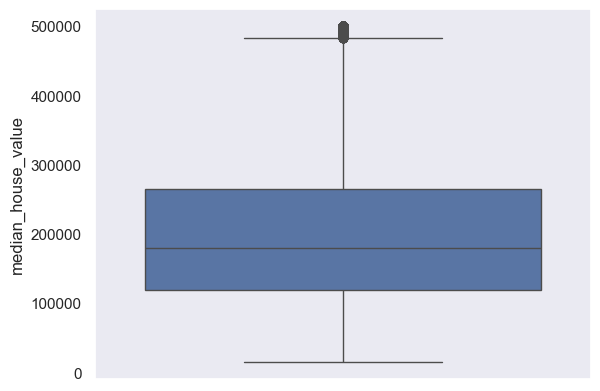

In [83]:
#outliers and boxplot for median_house_value
sns.boxplot(data=housing_data,y='median_house_value')

In [84]:
def remove_outliers(data, column):
    q1 = data[column].quantile(0.25)
    q3 = data[column].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    len_initial = len(data)
    data_filtered = data.loc[(data[column] <= upper_bound) & (data[column] >= lower_bound)]
    len_final = len(data_filtered)
    outliers_removed = len_initial - len_final    
    print(f"# of outliers removed = {outliers_removed}")
    return data_filtered

housing_data = remove_outliers(train_set,'median_house_value')

# of outliers removed = 866


#### Pair plotting the meaningful features of the dataset 

<Figure size 1500x1000 with 0 Axes>

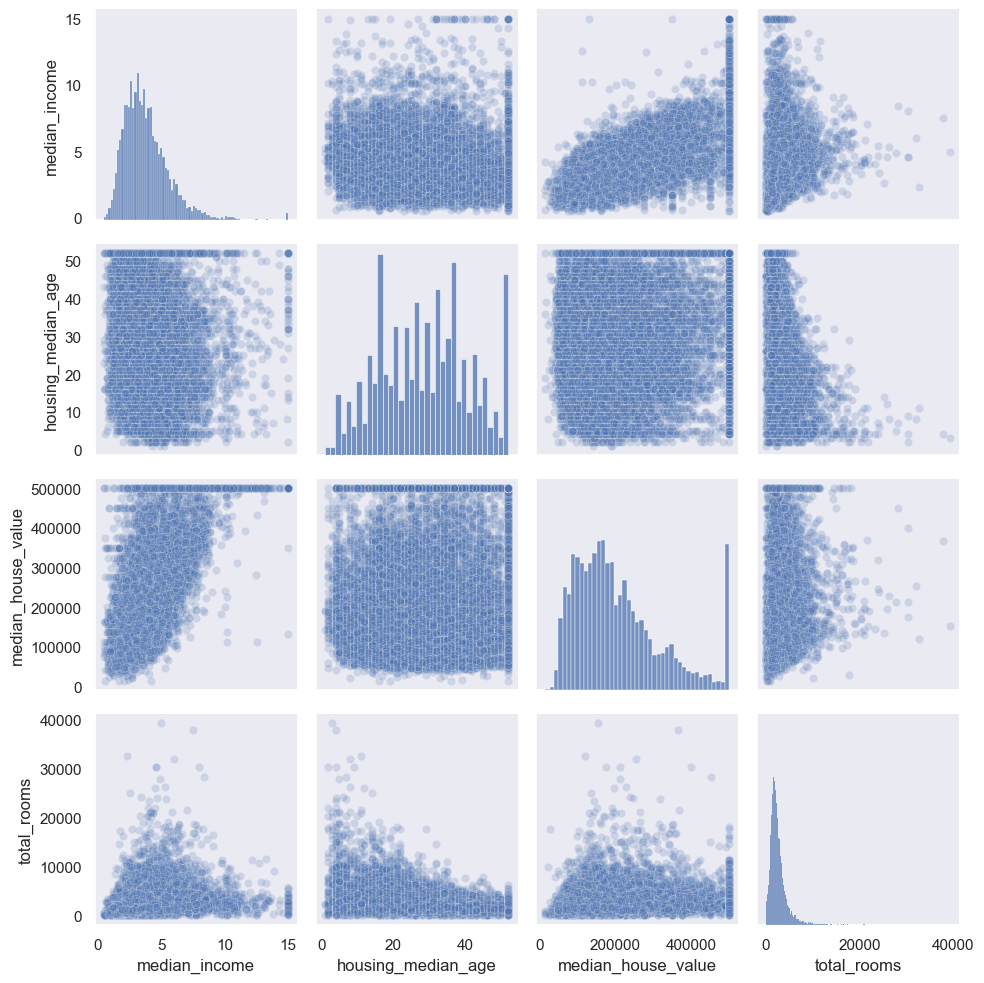

In [85]:
attributes = ['median_income','housing_median_age','median_house_value','total_rooms']
plt.figure(figsize=(15,10))
sns.pairplot(data=train_set[attributes],plot_kws={'alpha':0.2})
plt.tight_layout()
plt.show()

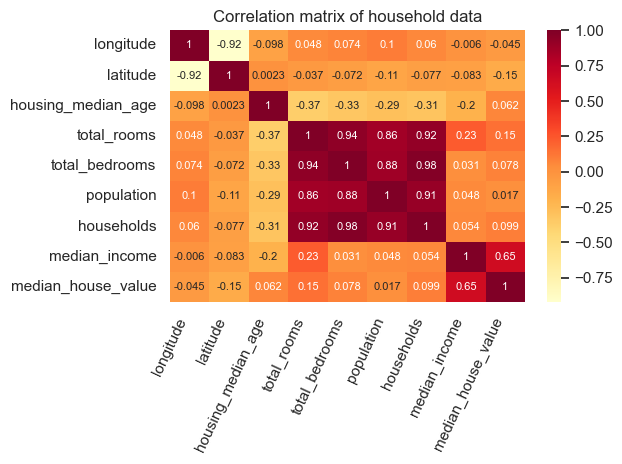

In [86]:
#### plotting the correlation matrix
plt.title("Correlation matrix of household data")
sns.heatmap(data=housing_data.select_dtypes(include='number').corr(),annot=True,cmap='YlOrRd',cbar=True,annot_kws={"size": 8})
plt.xticks(rotation=65,ha='right')
plt.tight_layout()

### Using cluster similarity to get the similarity measure of the lattitude and longitude to their associated cluster centers . 

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.utils.validation import check_is_fitted,check_array



# fit method of custom transformers always X and y as parameters else the pipelines dont work as intended
# they will take and return ndarrays 
# constructor does not take *args or **kwargs in as parameters for the constructor
# fit and transform method always returns self 

class ClusterSimilarity(BaseEstimator,TransformerMixin):
  def __init__(self,n_clusters=10,gamma=1.,random_state=None,init='k-means++',n_init='auto'):
    self.random_state = random_state
    self.init = init
    self.n_init = n_init
    self.n_clusters = n_clusters
    self.gamma = gamma
    
  
  def fit(self,X,y=None,sample_weights=None):
    X = check_array(X)
    self.n_features_in_ = X.shape[1]
    self.kmeans_ = KMeans(n_clusters=self.n_clusters,random_state=self.random_state,init=self.init,n_init=self.n_init)
    assert self.n_features_in_ == X.shape[1]
  
    # Fit KMeans with sample weights if provided
    #sample weights are nothing but a list of integers from 1 to inf which indicates the weights of the individual data points . This allows the algorithm to perform a weighted average rather than a simple average.
    self.kmeans_.fit(X,**({} if sample_weights is None else {'sample_weight':sample_weights}))
    return self
  
  def transform(self,X):
    check_is_fitted(self)
    X = check_array(X)
    return rbf_kernel(X,Y=self.kmeans_.cluster_centers_,gamma=self.gamma)
  
  def get_feature_names_out(self,names=None):
    return [f"Cluster {i} similarity" for i in range(self.n_clusters)]




#### Some pointers in the above implementation
- if there are n clusters and m data points in the matrix . then the ouput of the rbf kernel is a m*n matrix. This function is not a one-one mapping.
- the rbf kernel calculates the similarity score (or the kernel value) between each data point against all the clusters. 
- K(x,y) = e^((-|x-y||^2)/(2*(sigma^2)))
- We take the max value inorder to obtain the maximum cluster similarity

In [88]:
similarities = ClusterSimilarity(random_state=42,n_clusters=10,n_init=5)
cluster_sim = similarities.fit_transform(housing_data[['latitude','longitude']],sample_weights=housing_data['median_house_value'])
max_cluster_similarity = np.max(cluster_sim,axis=1)
max_cluster_similarity

array([0.97387671, 0.85352222, 0.941602  , ..., 0.92194702, 0.94187536,
       0.97084004])

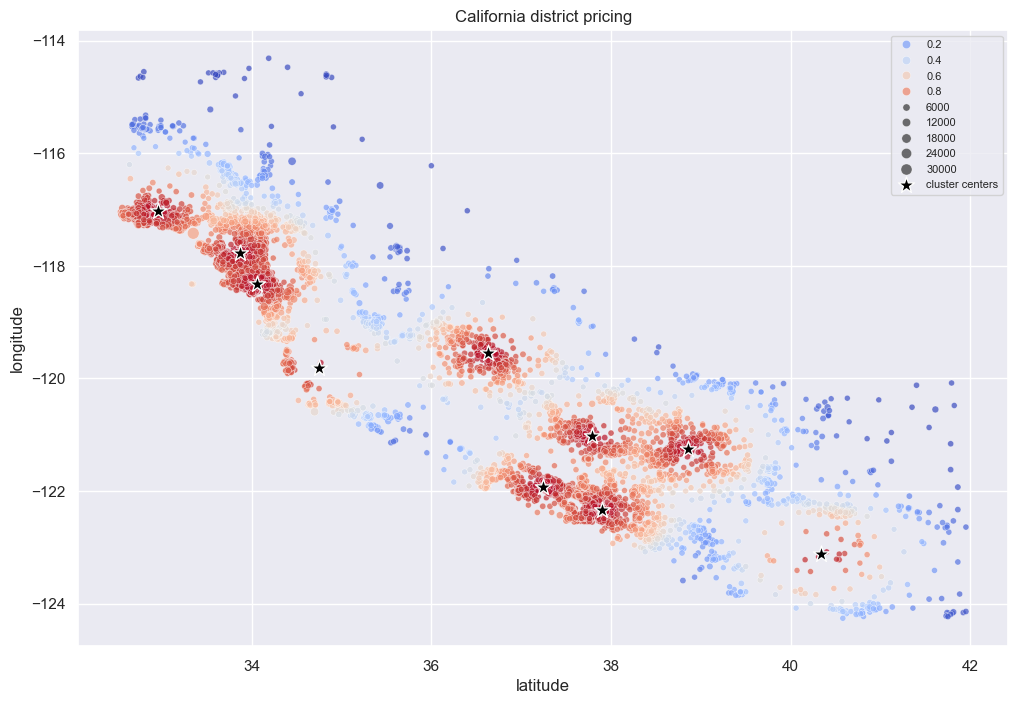

In [89]:
### Plotting the lattitude vs longitude to visualize the district prices 
plt.figure(figsize=(12,8))
sns.scatterplot(data=housing_data,x='latitude',y='longitude',alpha=0.7,size='population',hue=max_cluster_similarity,palette='coolwarm')
clust_lat = similarities.kmeans_.cluster_centers_[:,0]
clust_long = similarities.kmeans_.cluster_centers_[:,1]
sns.scatterplot(x=clust_lat,y=clust_long,marker='*',color='black',s=150,label='cluster centers')
plt.title("California district pricing")
plt.legend(fontsize=8)
plt.grid(True)

In [90]:
### Instead of the Transformer send 'drop' to drop the columns
### send 'passthrough' for the leaving the columns as it is

#### We can use the pipelines as follows
- In the pipeline the last estimator can be a transformer, predictor or any other type of estimator. The rest of the items must be transformers i.e implement the fit_transform method. 

In [91]:
#Syntax 1 
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
pipeline  = Pipeline(steps=[("name_2",SimpleImputer(strategy='mean')),("name_of_pipline",StandardScaler())])

#to access the first estimator we can say 
print(pipeline[-1])  # this gives me access to the last estimator using indexing method
print(pipeline.named_steps['name_of_pipline']) # using the named steps method

#Syntax 2
pipeline2 = make_pipeline(SimpleImputer(strategy='median'),StandardScaler())
print(pipeline2[0],pipeline2.named_steps['simpleimputer']) #Give the class names in small characters to access the estimators

StandardScaler()
StandardScaler()
SimpleImputer(strategy='median') SimpleImputer(strategy='median')


#### Below we define sample syntax for ColumnTransformer

In [ ]:
# Column transformer syntax 

from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler,FunctionTransformer,OneHotEncoder


# In the similar manner to above ColumnTransformer provides explicit naming while the make_column_transformer names it pipeline-1 , pipeline-2 etc

ct = make_column_transformer([(pipeline,['housing_median_age']),(pipeline2,['total_rooms'])])
print(ct.transformers) # Get access to the pipeline by unpacking this tuple

[('tuple', (Pipeline(steps=[('name_2', SimpleImputer()),
                ('name_of_pipline', StandardScaler())]), ['housing_median_age']), (Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())]), ['total_rooms']))]


In [93]:
def column_ratio(X):
  return X[:,[0]]/X[:,[1]]
def ratio_name(function_transformer,feature_names_in):
  return ["ratio"]

ratio_pipeline = make_pipeline(SimpleImputer(strategy='median'),FunctionTransformer(column_ratio,feature_names_out=ratio_name))

log_pipeline = make_pipeline(SimpleImputer(strategy='median'),FunctionTransformer(np.log,feature_names_out="one-to-one",inverse_func=np.exp),StandardScaler())

catpipeline = make_pipeline(SimpleImputer(strategy='most_frequent'),OneHotEncoder(handle_unknown='ignore'))

num_pipeline = make_pipeline(SimpleImputer(strategy='median'),StandardScaler())

preprocessing = ColumnTransformer(transformers=[("rooms_per_household",ratio_pipeline,["total_rooms","households"]),("people_per_household",ratio_pipeline,["population","households"]),("bedrooms_per_household",ratio_pipeline,["total_bedrooms","total_rooms"]),("geo",similarities,["latitude","longitude"]),("log",log_pipeline,["total_bedrooms","total_rooms","population","households","median_income"]),("cat_pipeline",catpipeline,["ocean_proximity"])],remainder=num_pipeline,force_int_remainder_cols=False)


In [94]:
housing_prepared = preprocessing.fit_transform(housing_data)

In [95]:
housing_df_prepared = pd.DataFrame(housing_prepared,columns=preprocessing.get_feature_names_out())
housing_df_prepared.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15646 entries, 0 to 15645
Data columns (total 26 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   rooms_per_household__ratio                15646 non-null  float64
 1   people_per_household__ratio               15646 non-null  float64
 2   bedrooms_per_household__ratio             15646 non-null  float64
 3   geo__Cluster 0 similarity                 15646 non-null  float64
 4   geo__Cluster 1 similarity                 15646 non-null  float64
 5   geo__Cluster 2 similarity                 15646 non-null  float64
 6   geo__Cluster 3 similarity                 15646 non-null  float64
 7   geo__Cluster 4 similarity                 15646 non-null  float64
 8   geo__Cluster 5 similarity                 15646 non-null  float64
 9   geo__Cluster 6 similarity                 15646 non-null  float64
 10  geo__Cluster 7 similarity         

### We will use the regression , decision tree regressor and then random forest regressor for predicting the housing values . 
- We will evaluate the performance on different models and see which performs well

In [96]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

dt_reg = DecisionTreeRegressor(random_state=42)
dt_reg_pipeline = make_pipeline(preprocessing,dt_reg)


lin_reg = LinearRegression()
lin_reg_pipeline = make_pipeline(preprocessing,lin_reg)


rf_regressor = RandomForestRegressor(random_state=42)
forest_pipeline = make_pipeline(preprocessing,rf_regressor)


In [97]:
X_train,y_train = housing_data.drop("median_house_value",axis=1),housing_data.loc[:,["median_house_value"]]
X_test,y_test = test_set.drop("median_house_value",axis=1),test_set.loc[:,["median_house_value"]]

#### Evaluating the Linear Regression model

In [98]:
from sklearn.metrics import root_mean_squared_error

lin_reg_pipeline.fit(X_train,y_train)
y_pred = lin_reg_pipeline.predict(X_test)
score = root_mean_squared_error(y_test,y_pred)
print(score)

71219.91143282269


#### Evaluating the DecisionTreeRegressor

In [99]:
dt_reg_pipeline.fit(X_train,y_train)
y_pred_tree = dt_reg_pipeline.predict(X_test)
tree_rmse  = root_mean_squared_error(y_test,y_pred_tree)
print(tree_rmse)

66778.61452584049


#### Evaluating the RandomForest Regressor using cross validation technique

In [100]:
# Warning! This cell will take a while to execute. 

from sklearn.model_selection import GridSearchCV
import joblib 
import os

model_file_name = 'best_rf_model.pkl'
model_params_file_name = 'best_params.pkl'
best_model = None
rf_pipeline = Pipeline(steps=[("preprocessing",preprocessing),("rf",RandomForestRegressor(random_state=42))])
  

if(os.path.exists(model_file_name)):
  best_model = joblib.load(model_file_name)
  best_params = joblib.load(model_params_file_name)
  print("Loaded model from disk")
  print("Best parameters:", best_params)
else :

  param_grid = [
      {
          'preprocessing__geo__n_clusters': [5, 8, 10],
          'rf__max_features': [4, 6, 8],
          'preprocessing__geo__init':['k-means++','random'],
          'rf__min_samples_split':[2,3,4]
      },
      {
          'preprocessing__geo__n_clusters': [10, 15],
          'rf__max_features': ['sqrt','log2',None],
          'preprocessing__geo__init':['k-means++','random'],
          'preprocessing__geo__n_init':['auto',4,5],
          'rf__min_samples_split':[2,5,7]
      }
  ]


  grid_search = GridSearchCV(rf_pipeline, param_grid, scoring='neg_root_mean_squared_error', cv=3,n_jobs=-1,verbose=2)
  grid_search.fit(X_train, y_train.to_numpy().ravel())
  # Output best parameters
  print("Best parameters:", grid_search.best_params_)
  print("Best cross-validation score:", grid_search.best_score_)
  best_model = grid_search.best_estimator_
  best_params = grid_search.best_params_
  joblib.dump(best_model,model_file_name)
  joblib.dump(grid_search.best_params_,model_params_file_name)  
  


Loaded model from disk
Best parameters: {'preprocessing__geo__init': 'random', 'preprocessing__geo__n_clusters': 15, 'preprocessing__geo__n_init': 4, 'rf__max_features': 'sqrt', 'rf__min_samples_split': 2}


In [101]:
best_model.get_params().keys() #get the list of all the parameters that can be tuned in the pipeline

dict_keys(['memory', 'steps', 'verbose', 'preprocessing', 'rf', 'preprocessing__force_int_remainder_cols', 'preprocessing__n_jobs', 'preprocessing__remainder__memory', 'preprocessing__remainder__steps', 'preprocessing__remainder__verbose', 'preprocessing__remainder__simpleimputer', 'preprocessing__remainder__standardscaler', 'preprocessing__remainder__simpleimputer__add_indicator', 'preprocessing__remainder__simpleimputer__copy', 'preprocessing__remainder__simpleimputer__fill_value', 'preprocessing__remainder__simpleimputer__keep_empty_features', 'preprocessing__remainder__simpleimputer__missing_values', 'preprocessing__remainder__simpleimputer__strategy', 'preprocessing__remainder__standardscaler__copy', 'preprocessing__remainder__standardscaler__with_mean', 'preprocessing__remainder__standardscaler__with_std', 'preprocessing__remainder', 'preprocessing__sparse_threshold', 'preprocessing__transformer_weights', 'preprocessing__transformers', 'preprocessing__verbose', 'preprocessing__ve

In [102]:
#Analysing the results of the search
if not os.path.exists(model_file_name):
  results_df = pd.DataFrame(grid_search.cv_results_)
  results_df.sort_values(ascending=False,by='mean_test_score',inplace=True)
  results_df["mean_test_rmse"]= np.abs(results_df["mean_test_score"])
  results_df.drop(["mean_test_score"],axis=1,inplace=True)
  results_df.head()

#### Randomized CV search
- randint() function returns a random variable object which represents a uniform distribution between the provided high and low. 
- RandomizedSearch will sample values from it randomly. To get the values we can say 
- randint(10,50).rvs(size=10) will get 10 values from the distribution

In [103]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distributions = {
    'preprocessing__geo__n_clusters': randint(3, 20),  
    'rf__max_features': randint(1, X_train.shape[1]),  
    'rf__min_samples_split': randint(2, 20),  
    'rf__bootstrap': [True, False], 
    'rf__min_samples_leaf': randint(1, 20)  
}
rand_cv = RandomizedSearchCV(param_distributions=param_distributions,estimator=rf_pipeline,scoring='neg_root_mean_squared_error',random_state=42,n_iter=10,n_jobs=-1,verbose=2,cv=3)
model_path = "./models/best_rf_model2.pkl"
best_model2 = None
if not os.path.exists(model_path):
  os.makedirs(os.path.dirname(model_path),exist_ok=True)
  rand_cv.fit(X_train,y_train.to_numpy().ravel())
  best_model2 = rand_cv
  joblib.dump(rand_cv,model_path)
  print("model saved to disk")
else :
  best_model2 = joblib.load('best_rf_model2.pkl')
  print("model loaded from disk")

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END preprocessing__geo__n_clusters=5, rf__bootstrap=False, rf__max_features=5, rf__min_samples_leaf=2, rf__min_samples_split=13; total time=   8.5s
[CV] END preprocessing__geo__n_clusters=5, rf__bootstrap=False, rf__max_features=5, rf__min_samples_leaf=2, rf__min_samples_split=13; total time=   8.5s
[CV] END preprocessing__geo__n_clusters=13, rf__bootstrap=False, rf__max_features=5, rf__min_samples_leaf=4, rf__min_samples_split=9; total time=   8.7s
[CV] END preprocessing__geo__n_clusters=13, rf__bootstrap=False, rf__max_features=5, rf__min_samples_leaf=4, rf__min_samples_split=9; total time=   9.0s
[CV] END preprocessing__geo__n_clusters=13, rf__bootstrap=False, rf__max_features=5, rf__min_samples_leaf=4, rf__min_samples_split=9; total time=   9.1s
[CV] END preprocessing__geo__n_clusters=14, rf__bootstrap=True, rf__max_features=1, rf__min_samples_leaf=10, rf__min_samples_split=17; total time=   1.6s
[CV] END preprocessi

In [104]:
## delete files and directory contents. Will not delete directory if there are file contents in it 
def remove_files(directory='models',file_names=[],rm_directory=False):
  if not os.path.exists(directory):
    print("Directory does not exist. Please provide valid directory")
  else :
    for file_name in file_names:
      file_path = f"./{directory}/{file_name}"
      if(os.path.isfile(file_path)):
        os.remove(file_path)
        print(f"File: {file_name} is deleted successfully")
      else: 
        print(f"{file_name} is not a valid file or the path to the file does not exist") 
  try:
    if rm_directory:
      os.rmdir(directory)
      print(f"Directory '{directory}' removed successfully")
  except OSError as e:
    print(f"Directory is not empty: {e}")          
     

In [106]:
# Looking at the metrics of Randomized Search CV
print(best_model2.best_params_,best_model2.best_score_)

{'preprocessing__geo__n_clusters': 13, 'rf__bootstrap': False, 'rf__max_features': 5, 'rf__min_samples_leaf': 4, 'rf__min_samples_split': 9} -40268.953110434384


In [ ]:
pd.DataFrame(best_model2.cv_results_).describe()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_preprocessing__geo__n_clusters,param_rf__max_features,param_rf__min_samples_leaf,param_rf__min_samples_split,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
count,10.000000,10.000000,10.000000,10.000000,10.0000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.00000
mean,11.610210,0.157287,0.136679,0.011262,8.9000,9.700000,5.500000,5.700000,-42360.932495,-42606.048447,-42938.817312,-42635.266084,339.673958,5.50000
std,6.758207,0.166521,0.017184,0.012917,3.3483,5.982382,2.013841,1.337494,1059.105631,1183.690871,1086.269870,1073.264261,128.424960,3.02765
min,2.548401,0.013860,0.111656,0.000812,4.0000,2.000000,2.000000,4.000000,-44882.094112,-44257.833596,-44707.282441,-44568.850314,198.298771,1.00000
25%,6.604041,0.075225,0.125539,0.003295,6.2500,4.000000,4.250000,4.250000,-42500.153602,-43271.810629,-43516.076389,-43053.383244,253.100090,3.25000
50%,10.061365,0.091031,0.138304,0.007904,9.0000,11.000000,6.000000,6.000000,-42335.493465,-42683.838099,-43104.572544,-42750.722043,296.715025,5.50000
75%,17.474623,0.182874,0.144535,0.012616,10.5000,14.500000,6.750000,7.000000,-41721.477168,-41741.719692,-41987.776055,-41716.767918,375.817538,7.75000
max,23.053462,0.584050,0.163080,0.044281,14.0000,18.000000,8.000000,7.000000,-41121.559748,-40733.100285,-41469.026221,-41166.224610,592.698741,10.00000


In [107]:
final_model = best_model2.best_estimator_
feature_imp = final_model["rf"].feature_importances_
sorted(zip(feature_imp,final_model["preprocessing"].get_feature_names_out()),reverse=True)

[(0.1722012437416792, 'log__median_income'),
 (0.13031467205175887, 'remainder__income_cat'),
 (0.12184010694299947, 'cat_pipeline__ocean_proximity_INLAND'),
 (0.06294057083174617, 'people_per_household__ratio'),
 (0.055851840978271027, 'geo__Cluster 3 similarity'),
 (0.045004357559431156, 'bedrooms_per_household__ratio'),
 (0.03845784689062794, 'geo__Cluster 6 similarity'),
 (0.03525190233934096, 'geo__Cluster 0 similarity'),
 (0.032726102054862545, 'rooms_per_household__ratio'),
 (0.032712100507612696, 'geo__Cluster 10 similarity'),
 (0.03131960344466579, 'geo__Cluster 2 similarity'),
 (0.029379366371091134, 'geo__Cluster 7 similarity'),
 (0.026231851152025566, 'geo__Cluster 9 similarity'),
 (0.0247364888398393, 'geo__Cluster 8 similarity'),
 (0.022865005046012302, 'geo__Cluster 12 similarity'),
 (0.02000329294464929, 'geo__Cluster 5 similarity'),
 (0.018458225386286012, 'remainder__housing_median_age'),
 (0.01768103215538232, 'geo__Cluster 1 similarity'),
 (0.01614163613087395, 'cat

#### Evaluation on the test set

In [108]:
final_y_predictions = final_model.predict(X_test)
final_rmse = root_mean_squared_error(y_test,final_y_predictions)
print(final_rmse)

50396.98137303234


#### calculates the confidence interval of the mean of squared errors.
- formula is myu +/- t_score(95%) * s/root(n) 
- The scale parameter in the above eqn is the standard error of the mean (s/root(n)) 
- the degrees of freedom is used to calculate the standard deviation of the sample. 
- root((1/(n-1)) * (sum(x(i) - xbar)^2)) 

In [109]:
from scipy import stats as st

sqr_errors = (final_y_predictions - y_test.to_numpy().ravel()) ** 2
ci = np.sqrt(st.t.interval(confidence=0.95,df=len(sqr_errors)-1,loc=np.mean(sqr_errors),scale=(st.sem(sqr_errors))))

print(f"Confidence interval for the RMSE: {ci}")

Confidence interval for the RMSE: [47845.99433495 52824.92109911]
